In [1]:
import pandas as pd
#import geopandas as gpd
import numpy as np

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import os

import warnings
warnings.filterwarnings("ignore")

import datetime
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

from datetime import date, timedelta

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date       # as timedelta

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

In [5]:
twt_ods = read_OD_fn('TWT')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [6]:
lista = []

for date in tqdm_notebook(target_days):
    lista.append(ine_ods[date].loc['total','total'])

  0%|          | 0/81 [00:00<?, ?it/s]

In [7]:
df = pd.DataFrame (lista, columns = ['Viajes'], index= target_days)

In [8]:
df.head()

,Viajes
2020-04-01,2213123
2020-04-02,2254121
2020-04-03,2520095
2020-04-04,1934554
2020-04-05,1593385


# Visualización de datos

In [9]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [10]:
print(len(df['2020']))

81


In [11]:
df.describe()

,Viajes
count,8.100000e+01
mean,3.438222e+06
std,1.174931e+06
min,1.535886e+06
25%,2.488436e+06
50%,3.396402e+06
75%,4.445190e+06
max,5.519725e+06


In [12]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,2.356878e+06
2020-05-31,3.590722e+06
2020-06-30,4.823862e+06


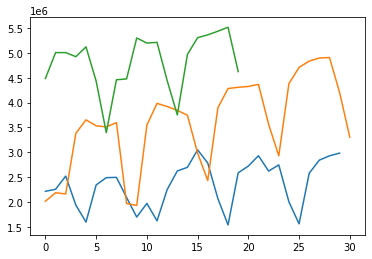

In [13]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [14]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

PASOS=7 #preguntar

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# cargamos el dataframe en la variable values
values = df.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, PASOS, 1)

#imprimimos los nuevos datos
reframed.tail()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
76,0.477061,0.891413,0.839957,0.847171,0.460553,0.113062,0.725623,0.894152
77,0.891413,0.839957,0.847171,0.460553,0.113062,0.725623,0.894152,0.923149
78,0.839957,0.847171,0.460553,0.113062,0.725623,0.894152,0.923149,0.959687
79,0.847171,0.460553,0.113062,0.725623,0.894152,0.923149,0.959687,1.000000
80,0.460553,0.113062,0.725623,0.894152,0.923149,0.959687,1.000000,0.551599


# Dividimos los datos en sets de entrenamiento y validacion

In [15]:
#dividimos nuestro valores entre sets de entrenamiento y de test
values = reframed.values
n_train_days = 75 - (5+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features] - preguntar
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(63, 1, 7) (63,) (11, 1, 7) (11,)


# Creamos la red neuronal

In [16]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [17]:
EPOCHS=80

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 7)              56        
_________________________________________________________________
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
9/9 [==============================] - 2s 142ms/step - loss: 0.3729 - mse: 0.1996 - val_loss: 0.5056 - val_mse: 0.3160
Epoch 2/80
9/9 [==============================] - 0s 5ms/step - loss: 0.4031 - mse: 0.2390 - val_loss: 0.4679 - val_mse: 0.2706
Epoch 3/80
9/9 [==============================] - 0s 4ms/step - loss: 0.3808 - mse: 0.2034 - val_loss: 0.4364 - val_mse: 0.2354
Epoc

Epoch 59/80
9/9 [==============================] - 0s 5ms/step - loss: 0.1190 - mse: 0.0282 - val_loss: 0.1249 - val_mse: 0.0213
Epoch 60/80
9/9 [==============================] - 0s 5ms/step - loss: 0.1093 - mse: 0.0254 - val_loss: 0.1250 - val_mse: 0.0213
Epoch 61/80
9/9 [==============================] - 0s 5ms/step - loss: 0.1154 - mse: 0.0254 - val_loss: 0.1243 - val_mse: 0.0209
Epoch 62/80
9/9 [==============================] - 0s 5ms/step - loss: 0.1167 - mse: 0.0274 - val_loss: 0.1248 - val_mse: 0.0210
Epoch 63/80
9/9 [==============================] - 0s 5ms/step - loss: 0.1127 - mse: 0.0267 - val_loss: 0.1255 - val_mse: 0.0214
Epoch 64/80
9/9 [==============================] - 0s 5ms/step - loss: 0.1332 - mse: 0.0328 - val_loss: 0.1261 - val_mse: 0.0216
Epoch 65/80
9/9 [==============================] - 0s 5ms/step - loss: 0.1194 - mse: 0.0278 - val_loss: 0.1267 - val_mse: 0.0217
Epoch 66/80
9/9 [==============================] - 0s 5ms/step - loss: 0.1350 - mse: 0.0360 - val

# Visualizamos resultados

In [18]:
results=model.predict(x_val)
print(len(results))

11


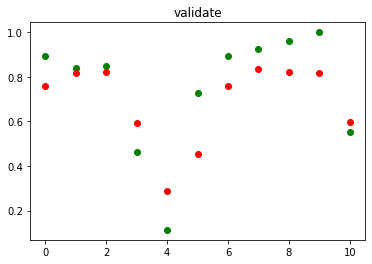

In [19]:
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

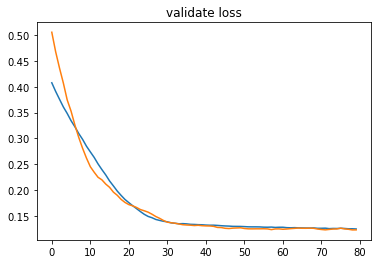

In [20]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

# Prediccion a futuro

In [21]:
# usaremos los 14 ultimos dias del confinamiento en junio para predecir como habrian sido los dias del 21 al 27 en caso de que
# el confinamiento se hubiese alargado por una semana mas

ultimosDias = df['2020-6-7':'2020-6-20']
ultimosDias

,Viajes
2020-06-07,3396402
2020-06-08,4461143
2020-06-09,4478072
2020-06-10,5303428
2020-06-11,5200931
2020-06-12,5215302
2020-06-13,4445190
2020-06-14,3753016
2020-06-15,4973188
2020-06-16,5308885


# Preparamos los datos para el test

In [22]:
# cargamos el dataframe en la variable values
values = ultimosDias.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, PASOS, 1)

# eliminamos la ultima columna pues es parte de lo que queremos hayar
reframed.drop(reframed.columns[[7]], inplace=True, axis=1)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-1.000000,0.002901,0.018846,0.796266,0.699721,0.713258,-0.012126
8,0.002901,0.018846,0.796266,0.699721,0.713258,-0.012126,-0.664099
9,0.018846,0.796266,0.699721,0.713258,-0.012126,-0.664099,0.485206
10,0.796266,0.699721,0.713258,-0.012126,-0.664099,0.485206,0.801405
11,0.699721,0.713258,-0.012126,-0.664099,0.485206,0.801405,0.855810
12,0.713258,-0.012126,-0.664099,0.485206,0.801405,0.855810,0.924364
13,-0.012126,-0.664099,0.485206,0.801405,0.855810,0.924364,1.000000


In [23]:
values = reframed.values

#tomamos los valores para realizar el test
x_test = values[6:, :]

# reshape input to be 3D [samples, timesteps, features] - preguntar
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[-0.01212597, -0.6640985 ,  0.48520565,  0.80140543,
          0.8558097 ,  0.9243636 ,  1.        ]]], dtype=float32)

In [24]:
#definimos la funcion para realizar el desplazamiento que se hara en el array cada prediccion pues para hacer
#la siguiente prediccion eliminamos el dia mas antiguo, desplazamos un lugar el resto de dias y añadimos el ultimo dia que
#se ha predecido, esto es por que para predecir un dia se usan los 7 dias previos

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

# Predicciones para la proxima semana

In [25]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-0.01212597 -0.6640985   0.48520565  0.80140543  0.8558097
    0.9243636   1.        ]]]
[[[-0.6640985   0.48520565  0.80140543  0.8558097   0.9243636
    1.          0.36509195]]]
[[[ 0.48520565  0.80140543  0.8558097   0.9243636   1.
    0.36509195 -0.15532109]]]
[[[ 0.80140543  0.8558097   0.9243636   1.          0.36509195
   -0.15532109  0.43586645]]]
[[[ 0.8558097   0.9243636   1.          0.36509195 -0.15532109
    0.43586645  0.7782045 ]]]
[[[ 0.9243636   1.          0.36509195 -0.15532109  0.43586645
    0.7782045   0.8261887 ]]]
[[[ 1.          0.36509195 -0.15532109  0.43586645  0.7782045
    0.8261887   0.86674196]]]


# Re-Convertimos los resultados

In [26]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.36509195], dtype=float32), array([-0.15532109], dtype=float32), array([0.43586645], dtype=float32), array([0.7782045], dtype=float32), array([0.8261887], dtype=float32), array([0.86674196], dtype=float32), array([0.8559945], dtype=float32)]


array([[4845667.76801735],
       [4293165.29272042],
       [4920806.32320044],
       [5284253.44700104],
       [5335196.40518372],
       [5378250.25138746],
       [5366840.11615728]])

# Visualizamos el pronostico

<AxesSubplot:>

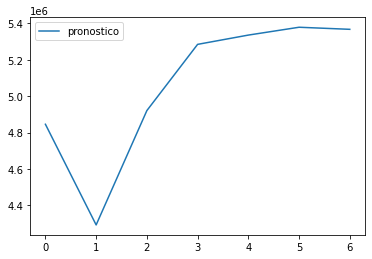

In [27]:
prediccion = pd.DataFrame(inverted)
prediccion.columns = ['pronostico']
prediccion.plot()

# Prediccion con datos actuales

In [28]:
# usaremos 14 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error
Dias = df['2020-5-11':'2020-5-24']
Dias

,Viajes
2020-05-11,3545526
2020-05-12,3985384
2020-05-13,3922169
2020-05-14,3845239
2020-05-15,3745419
2020-05-16,2983259
2020-05-17,2430478
2020-05-18,3896788
2020-05-19,4284420
2020-05-20,4309613


# Preparamos los datos para el test

In [29]:
# cargamos el dataframe en la variable values
values = Dias.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, PASOS, 1)

# eliminamos la ultima columna pues es parte de lo que queremos hayar
reframed.drop(reframed.columns[[7]], inplace=True, axis=1)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,0.150527,0.604381,0.539155,0.459777,0.356781,-0.429630,-1.000000
8,0.604381,0.539155,0.459777,0.356781,-0.429630,-1.000000,0.512966
9,0.539155,0.459777,0.356781,-0.429630,-1.000000,0.512966,0.912932
10,0.459777,0.356781,-0.429630,-1.000000,0.512966,0.912932,0.938927
11,0.356781,-0.429630,-1.000000,0.512966,0.912932,0.938927,0.955663
12,-0.429630,-1.000000,0.512966,0.912932,0.938927,0.955663,1.000000
13,-1.000000,0.512966,0.912932,0.938927,0.955663,1.000000,0.169306


In [30]:
values = reframed.values

#tomamos los valores para realizar el test
x_test = values[6:, :]

# reshape input to be 3D [samples, timesteps, features] - preguntar
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[-1.        ,  0.51296616,  0.9129319 ,  0.9389267 ,
          0.9556627 ,  1.        ,  0.16930556]]], dtype=float32)

In [31]:
#en la linea 24 definimos la funcion para realizar el desplazamiento que se hara en el array cada prediccion pues para hacer
#la siguiente prediccion eliminamos el dia mas antiguo, desplazamos un lugar el resto de dias y añadimos el ultimo dia que
#se ha predecido, esto es por que para predecir un dia se usan los 7 dias previos, y que usaremos a continuación

# Realizamos la prediccion 

In [32]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-1.          0.51296616  0.9129319   0.9389267   0.9556627
    1.          0.16930556]]]
[[[ 0.51296616  0.9129319   0.9389267   0.9556627   1.
    0.16930556 -0.3111454 ]]]
[[[ 0.9129319   0.9389267   0.9556627   1.          0.16930556
   -0.3111454   0.40154457]]]
[[[ 0.9389267   0.9556627   1.          0.16930556 -0.3111454
    0.40154457  0.7936715 ]]]
[[[ 0.9556627   1.          0.16930556 -0.3111454   0.40154457
    0.7936715   0.8408266 ]]]
[[[ 1.          0.16930556 -0.3111454   0.40154457  0.7936715
    0.8408266   0.88109803]]]
[[[ 0.16930556 -0.3111454   0.40154457  0.7936715   0.8408266
    0.88109803  0.8403952 ]]]


# Re-Convertimos los resultados

In [33]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)
inverted

[array([-0.3111454], dtype=float32), array([0.40154457], dtype=float32), array([0.7936715], dtype=float32), array([0.8408266], dtype=float32), array([0.88109803], dtype=float32), array([0.8403952], dtype=float32), array([0.44372493], dtype=float32)]


array([[3098090],
       [3788802],
       [4168837],
       [4214538],
       [4253568],
       [4214120],
       [3829682]])

# Visualizamos el pronostico

<AxesSubplot:>

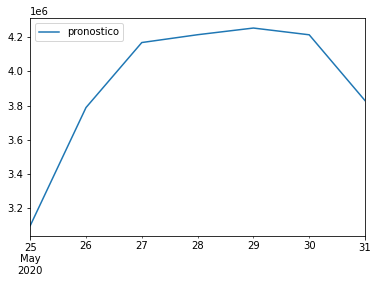

In [34]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [35]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']
compara

,real,prediccion
2020-05-25,4382232,3098090
2020-05-26,4709433,3788802
2020-05-27,4837770,4168837
2020-05-28,4898946,4214538
2020-05-29,4909824,4253568
2020-05-30,4202334,4214120
2020-05-31,3305717,3829682


<AxesSubplot:>

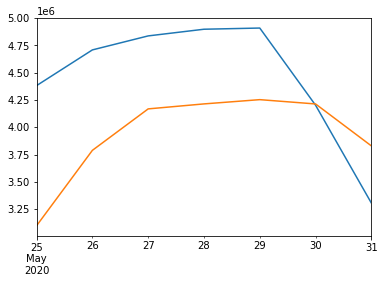

In [36]:
compara['real'].plot()
compara['prediccion'].plot()

In [37]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(prediccion, datosReales)

678588.7142857143

In [38]:
from sklearn.metrics import mean_squared_error

mean_squared_error(prediccion, datosReales)

588259707405.0